# Normalised Information Distance and Descriptor Metrics
---
<br>
<br>
In this notebook, NID and scene descriptor functions will be built and tested to ensure that they run properly. 

These can then be built into a standard .py script to be used as functions in other classes.


# Normalised Information Metric

For NIM we need: 
$$
D(X, Y ) = \frac{2H(X, Y ) − H(X) − H(Y )}{H(X, Y )}
$$


with,

$$H(X) = − \sum \limits^{}_{x∈X}{p_x log(p_x)}$$

$$H(Y) = −\sum \limits^{}_{y∈Y}{p_y log(p_y)}$$


## Imports and setup
<br>
<br>
<br>


In [1]:
%matplotlib notebook
# %matplotlib inline 
# If in Jupyter Lab

# If running dark mode
# from jupyterthemes import jtplot
# jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)


figpath = r"../Writeup/Figures/"

In [2]:
import numpy as np
import pykitti
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import cv2
import copy


from scipy.stats import norm, gaussian_kde

import statsmodels.api as sm

from IPython.display import display, Markdown



from PIL import Image

from GetPyKitti import getPyKittiData

In [3]:
data = getPyKittiData()
frame_num = 0
veloData = data.get_velo(frame_num)
pc_velo = veloData[:,:3]
camera_data = [
    data.get_cam0(frame_num),
    data.get_cam1(frame_num),
    data.get_cam2(frame_num),
    data.get_cam3(frame_num)
]
# data.calib # To check if the data is imported correctly



In [4]:
def pageBreak(num=6):
    md = ""
    for i in range(num):
        md = md + "<br>"

    display(Markdown(md))

## Functions

In [5]:
def get_img_hist(img, num_bins = 256):
    img = np.array(img)
    img_r = np.ravel(img)
    
    bin_ar = np.arange(0,num_bins)
    return np.histogram(img_r, bins=bin_ar)


def get_marginal_pdf_MSE(X):
    '''
    Calculates the probability density function of X
    Returns [Value, Probability] as a nx2 numpy array
    '''

    ind,u =np.unique(X,return_counts=True)
    pd = u / np.sum(u)
    unique = np.round(ind,decimals=2)

    p_x = np.vstack((unique, pd)).transpose()

    return (p_x)

In [6]:
# Unsmoothed MI scores

def get_probabilities(histo):
    p_joint = histo / np.sum(histo)
    p_x = np.sum(p_joint, axis=1)
    p_y = np.sum(p_joint, axis=0)

    px_py = p_x[:, None] * p_y[None, :]
    
    
    return p_joint, p_x, p_y, px_py
    

def get_mutual_info_score(x, y, threshold=3000,too_small_reduction = 0.1, use_hist = True):
    """
    Return the mutual information score for a joint histogram
    """
    
    X = np.array(x).ravel()
    Y = np.array(y).ravel()
    
    too_small = False
    
    if len(X)*len(Y) < threshold:
        too_small=True
    

    if use_hist:
        Z, _, _ = np.histogram2d(X, Y, bins=255)
    else:                   
        Z = get_kde_2D(X, Y)

    p_joint, p_x, p_y, px_py = get_probabilities(Z)
    non_zeros = p_joint > 0  # Only non-zero pxy values contribute to the sum

#     if too_small:
#         print("Overlap too small, reducing score")
#         return too_small_reduction * np.sum(p_joint[non_zeros] *
#                       np.log(p_joint[non_zeros] / px_py[non_zeros]))
#     else:
#         return np.sum(p_joint[non_zeros] *
#                       np.log(p_joint[non_zeros] / px_py[non_zeros]))
    
    
    return np.sum(p_joint[non_zeros] * np.log(p_joint[non_zeros] / px_py[non_zeros]))

    

In [7]:
from scipy.stats import entropy
def get_Normalised_mutual_info_score(x, y, threshold=3000,too_small_reduction = 0.1, use_hist = True):
    """
    Return the normalised mutual information score for a joint histogram
    """
#     if use_hist:    NMI = 2*get_mutual_info_score(x, y, threshold,too_small_reduction, use_hist)/(entropy(np.array(x).ravel()) + entropy(np.array(y).ravel()))
#     else:
#         NMI = 2*get_mutual_info_score(x, y, threshold,too_small_reduction, use_hist)/(entropy(np.array(x).ravel()) + entropy(np.array(y).ravel()))
    
    NMI = 2*get_mutual_info_score(x, y, threshold,too_small_reduction, use_hist)/(entropy(np.array(x).ravel()) + entropy(np.array(y).ravel()))
    return NMI

In [8]:
def make_proj_mat(P, Rrect, Rt):
    P_velo2cam_ref = Rt
    R_ref2rect = np.linalg.inv((Rrect))
    P_rect2cam2 = P

    proj_mat = P_rect2cam2 @ R_ref2rect @ P_velo2cam_ref
    return proj_mat

# Smoothing And Kernel Density Estimates
---


Silverman's rule of thumb:
$$ h=\left({\frac {4{\hat {\sigma }}^{5}}{3n}}\right)^{\frac {1}{5}}\approx 1.06\,{\hat {\sigma }}\,n^{-1/5}$$

## Functions


In [9]:
def get_omega(X, Y=None):
    """Returns the smoothing matrix kernel obtained by silverman's estimate of the form:
    [std(X), 0],[0, std(Y)]
    """
    if not Y:
        return 1.06 * (len(X)**(-1 / 5)) * np.std(X)
    else:
        n = len(X)
        omega = 1.06 * (n**(1 / 5)) * np.array([np.std(X), 0], [0, np.std(Y)])
        return omega

In [10]:
def get_kde_1D(X):
    """Return the smoothed kde for X"""
    w = get_omega(X)
    print("Bandwidth for kde: {}".format(w))
    kde = sm.nonparametric.KDEUnivariate(X)
    # kde.fit(bw=omega)  # Estimate the densities
    kde.fit(bw=(w))
    
#     tmp_bins = np.arange(0,255)/255
#     dig_inds = np.digitize(kde.support, bins=tmp_bins)
#     dig_1D_kde = np.zeros(2**8)
#     for i, inds in enumerate(dig_inds):
#         dig_1D_kde[inds] += kde.density[i]

#     dig_1D_kde = dig_1D_kde[1:]

#     return dig_1D_kde
    
    return kde


def get_kde_2D(im1,im2, returnXY = False):
    
    x, y = np.mgrid[0:255:256j, 0:255:256j,]
    positions = np.vstack([x.ravel(), y.ravel()])
#     values = np.vstack([im1, im2])
    values = np.vstack([im2, im1])
    kernel = gaussian_kde(values, bw_method='silverman')
    Z = np.reshape(kernel(positions).T, x.shape)
    
    if returnXY:
        return Z, x, y
    return Z


In [12]:
def kde2D(x, y, ax):
    from sklearn.neighbors import KernelDensity
   
    xy = np.vstack([x,y])

    d = xy.shape[0]
    n = xy.shape[1]
    bw = (n * (d + 2) / 4.)**(-1. / (d + 4)) # silverman
    #bw = n**(-1./(d+4)) # scott
    print('bw: {}'.format(bw))
    
    kde = KernelDensity(bandwidth=bw, metric='euclidean',
                        kernel='gaussian', algorithm='ball_tree')
    kde.fit(xy.T)
    
    xmin = x.min()
    xmax = x.max()
    ymin = y.min()
    ymax = y.max()
    
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()]).T

    Z = np.reshape(np.exp(kde.score_samples(positions.T)), X.shape)
    
    ax.imshow(np.rot90(Z), cmap=plt.cm.viridis,
              extent=[xmin, xmax, ymin, ymax])
    
    ax.scatter(x, y, c='k', s=5, edgecolor='')

    return Z, X, Y


## Plots

<IPython.core.display.Javascript object>


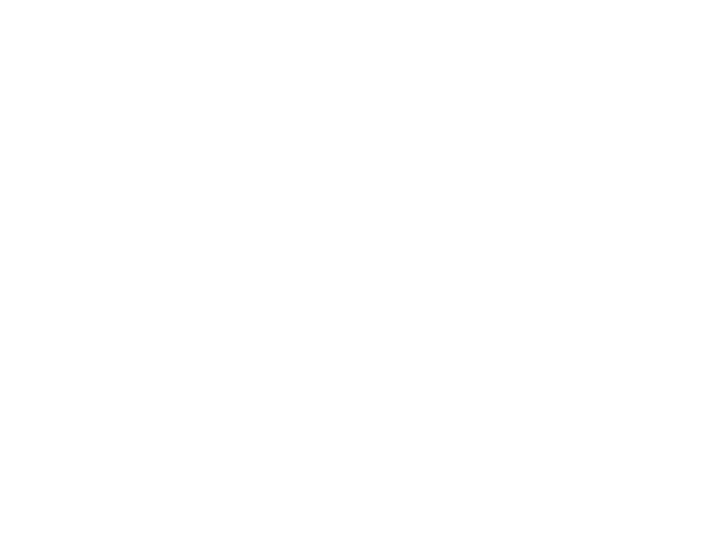

Text(0.5, 0.98, 'Comparison of two images from two of the cameras')

In [14]:
fig2im, ax2im = plt.subplots(2,1, figsize=(8,6))
fig2im.tight_layout(pad=3.5)
ax2im[0].imshow(camera_data[0], cmap="gray")
ax2im[0].set_title("Frame 0 from camera 1")
ax2im[0].axis('off')


ax2im[1].imshow(camera_data[1], cmap="gray")
ax2im[1].set_title("Frame 0 from camera 2")
ax2im[1].axis('off')

fig2im.suptitle("Comparison of two images from two of the cameras")



# fig2im.savefig(figpath+"Cam0Cam1.png")

In [15]:
from Lidar_Cam_Operations import *



In [16]:
shift_amount = 50

shift_1 = np.hstack((255*np.ones((camera_data[1].height, shift_amount)), np.array(camera_data[1])))
expand_0 = np.hstack((np.array(camera_data[0]), 255*np.ones((camera_data[1].height, shift_amount))))



print(shift_1.shape, expand_0.shape)

(375, 1292) (375, 1292)


<IPython.core.display.Javascript object>


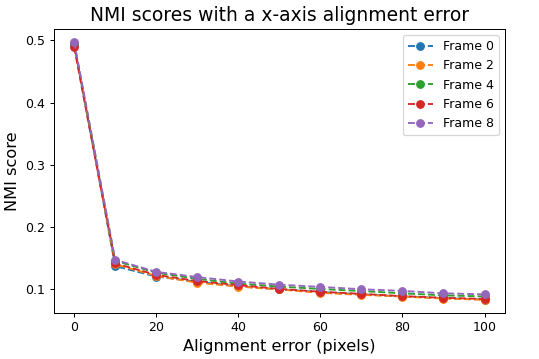

<IPython.core.display.Javascript object>


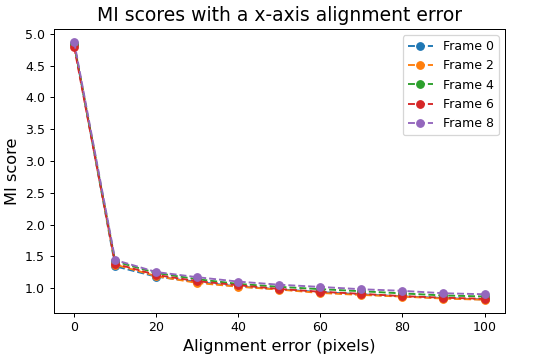

In [41]:
# from KDE_and_Mutual_Information import *




figgN, axgN = plt.subplots(1,1,figsize=(6,4))
figgN.tight_layout(pad=2.0)
axgN.set_title("NMI scores with a x-axis alignment error", fontsize=15)
axgN.set_xlabel("Alignment error (pixels)", fontsize=13)
axgN.set_ylabel("NMI score", fontsize=13)


figg, axg = plt.subplots(1,1,figsize=(6,4))
figg.tight_layout(pad=2.0)
axg.set_title("MI scores with a x-axis alignment error", fontsize=15)
axg.set_xlabel("Alignment error (pixels)", fontsize=13)
axg.set_ylabel("MI score", fontsize=13)



frame_nums = np.arange(0,9, 2)
shifts = np.arange(0,110,10)
MI_scores = np.zeros((frame_nums.shape[0], shifts.shape[0]))
NMI_scores =np.zeros((frame_nums.shape[0], shifts.shape[0]))
hist = True

for s, f in enumerate(frame_nums):
#     print("===============================================")
#     print("FRAME #{}".format(f*5))
#     print("===============================================")
    
    
#     velo_f = data.get_velo(f)
    img0_f = data.get_cam0(f)
    img1_f = data.get_cam0(f)
    
    for a,shift_amount in enumerate(shifts):
        shift_1 = np.hstack((255*np.ones((img0_f.height, shift_amount)), np.array(img1_f)))[::20]
        expand_0 = np.hstack((np.array(img0_f), 255*np.ones((img0_f.height, shift_amount))))[::20]

        NMI_scores[s,a] =(get_Normalised_mutual_info_score(shift_1, expand_0, use_hist=hist))
        MI_scores[s,a] =(get_mutual_info_score(shift_1, expand_0, use_hist=hist))


#         print("Shift:", shift_amount, "\tMI score:", MI_scores[s,a] )
#         print("Shift:", shift_amount, "\tNMI score:", NMI_scores[s,a])
        
        
        
        
    axg.plot(np.arange(0,110,10), MI_scores[s,:], 'o--', label="Frame {}".format(f))
    axgN.plot(np.arange(0,110,10), NMI_scores[s, :], 'o--', label="Frame {}".format(f))
    
        

axg.legend(loc='best')
axgN.legend(loc='best')


In [42]:
figg.savefig(figpath+"MIscore_align.png")

In [43]:
figgN.savefig(figpath+"NMIscore_align.png")

In [49]:
for c, sh in enumerate(shifts):
    print(sh, np.round(MI_scores[1,c],4), "\\\\")

0 4.8443 \\
10 1.372 \\
20 1.1903 \\
30 1.083 \\
40 1.0242 \\
50 0.9788 \\
60 0.9258 \\
70 0.8945 \\
80 0.8685 \\
90 0.8374 \\
100 0.819 \\


In [50]:
camera_data[0].height*camera_data[0].width

465750

0.0 4.836281906951478 284.6692803151552


<IPython.core.display.Javascript object>


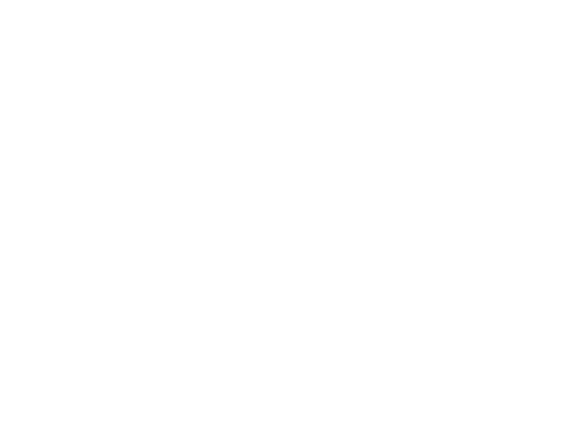

Text(0.5, 0, 'Pixels from Camera o')

In [20]:
hist_s, xedges, yedges, = np.histogram2d(shift_1.ravel()[::10], expand_0.ravel()[::10], bins=255)

hist_s_non_z = hist_s >0


hist_s[hist_s_non_z] = np.log(hist_s[hist_s_non_z])
ent_hist_s=hist_s/np.sum(hist_s)

# non_z = ent_hist_s>0
# ent_hist_s[non_z] = ent_hist_s[non_z]*np.log(ent_hist_s[non_z])
print(np.min(hist_s), np.max(hist_s), np.sum(hist_s))


fig_hist_s, ax_hist_s = plt.subplots(1,1)
ax_hist_s.imshow(ent_hist_s, interpolation='nearest', origin='low',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="twilight_shifted")
ax_hist_s.grid(color='w', linestyle='-', linewidth=0.3)

ax_hist_s.set_title("Logorithmic Histogram with the images not aligned")
ax_hist_s.set_ylabel("Pixels from Camera 1")
ax_hist_s.set_xlabel("Pixels from Camera o")

# fig_hist_s.savefig(figpath+"ShiftedHist.png")

In [21]:
hist, xedges, yedges = np.histogram2d(np.array(camera_data[0]).ravel()[::10], np.array(camera_data[1]).ravel()[::10],bins=255)#,normed=True)

In [22]:
hist_non_z = hist >0


hist[hist_non_z] = np.log(hist[hist_non_z])
ent_hist=hist/np.sum(hist)

# non_z = ent_hist>0
# ent_hist[non_z] = ent_hist[non_z]*np.log(ent_hist[non_z])
print(np.min(hist), np.max(hist), np.sum(hist))

0.0 8.067149039910106 9606.33253365655


<IPython.core.display.Javascript object>


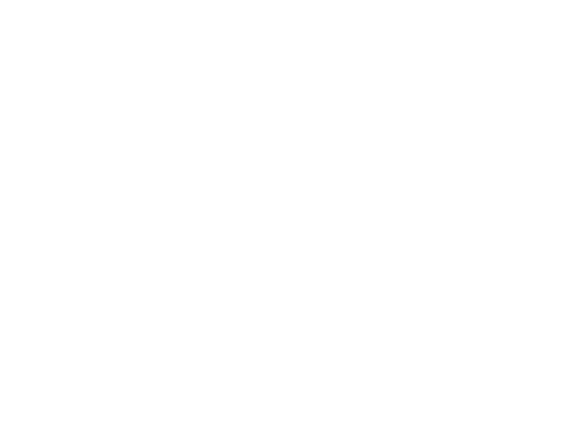

Text(0.5, 0, 'Pixels from Camera o')

In [23]:
fig_hist, ax_hist = plt.subplots(1,1)
ax_hist.imshow(ent_hist, interpolation='nearest', origin='low',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="twilight_shifted")
ax_hist.grid(color='w', linestyle='-', linewidth=0.3)

ax_hist.set_title("Logorithmic Histogram of images from the two grayscale cameras")
ax_hist.set_ylabel("Pixels from Camera 1")
ax_hist.set_xlabel("Pixels from Camera o")


# plt.savefig(figpath+"LogHist2imgs.png")

In [24]:

print("Original Score:", get_mutual_info_score(camera_data[1], camera_data[0]))
print("Shifted by" , shift_amount,":",get_mutual_info_score(shift_1, expand_0))

Original Score: 0.8367579377636181
Shifted by 100 : 0.8438581586343472


In [25]:
print("Original Score:", get_Normalised_mutual_info_score(camera_data[1], camera_data[0]) )
print("Shifted by" , shift_amount,":",get_Normalised_mutual_info_score(shift_1, expand_0))

Original Score: 0.06546954384715155
Shifted by 100 : 0.08563633715223057


## KDE plots
---
<br>
<br>
<br>
<br>


## 2D Mutual Information Histogram Plot

Using silverman's rule to find the bandwidth $\omega$ does not work as there is more than one peak in the distribution

Bandwidth for kde: 0.013596111142239135


<IPython.core.display.Javascript object>


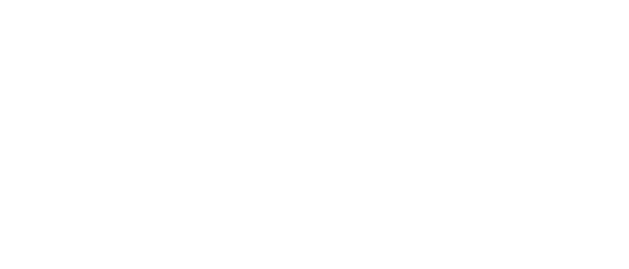

In [26]:
# pdf = get_marginal_pdf_MSE(veloData[:, 3])
# obs_dist = pdf[:,1]
obs_dist = veloData[:, 3]
discrete_values, _ = np.unique(veloData[:, 3], return_counts=True)
num_values = len(discrete_values)

kde = get_kde_1D(obs_dist)
fig = plt.figure(figsize=(7, 3))
ax = fig.add_subplot(111)
fig.tight_layout(pad=2.0)

pdf = get_marginal_pdf_MSE(obs_dist)
# ax.stem(pdf[:, 0]*255,
#         pdf[:, 1] * num_values, markerfmt = '.', 
# #         color='green',
#         label="Probability from sensor readings")
# markerline, stemlines, baseline = ax.stem(pdf[:, 0]*255,
#         pdf[:, 1] * num_values, markerfmt = ' ', 
# #         color='green',
#         label="Probability from sensor readings")
# plt.setp(stemlines, 'linewidth', 3)

# Plot the KDE as fitted using the default arguments
ax.plot(kde.support*255, (kde.density), lw=3, label='KDE from samples')#, zorder=10)
unbound_kde_density = np.copy(kde.density)
unbound_kde_support = np.copy(kde.support)

# Bounding to kde >=0:
neg_kde_part = kde.density[kde.support < 0]
kde.density[len(neg_kde_part):2 * len(neg_kde_part)] = np.add(
    kde.density[len(neg_kde_part):2 * len(neg_kde_part)],
    np.flip(neg_kde_part))
kde.density[0:len(neg_kde_part)] = np.subtract(
    kde.density[0:len(neg_kde_part)], neg_kde_part)


# Bounding to kde <=1
kde_g_1 = kde.density[kde.support > 1]
kde.density[-2 * len(kde_g_1):-len(kde_g_1)] = np.add(
    kde.density[-2 * len(kde_g_1):-len(kde_g_1)], kde_g_1)
kde.density[-len(kde_g_1):] = np.subtract(kde.density[-len(kde_g_1):], kde_g_1)

rng_kde = (kde.support >= 0) * (kde.support <= 1)
kde.density = kde.density[rng_kde]
kde.support = kde.support[rng_kde]

ax.plot(kde.support*255, (kde.density),
        lw=2,
        label='Bounded KDE from samples',
        zorder=10)
'''
-------------------------------------------------------------------

Smoothed pdf is kde.density
Corresponding intensity values are kde.support

-------------------------------------------------------------------
'''

# # Plot the samples
# samp = obs_dist[1::200]
# ax.scatter(samp,
#            -0.5 + np.abs(np.random.randn(samp.size)) / 9,
#            marker='x',
#            color='red',
#            zorder=20,
#            label='Samples',
#            alpha=0.5)

ax.legend(loc='best')
# ax.set_xlim(-0.5,1.5)
ax.grid(True, zorder=-5)

ax.set_ylabel("Density")
ax.set_xlabel("Intensity value")

fig.savefig(figpath + "1DKDEBounded.png" )

<IPython.core.display.Javascript object>


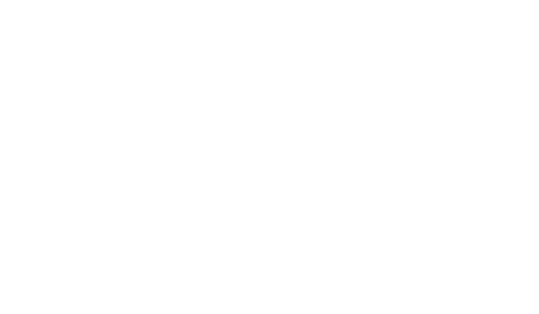

<ipython-input-27-0cc40341d4ae>:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  ax_ba_kde0.stem(pdf[:, 0]*255,


<IPython.core.display.Javascript object>


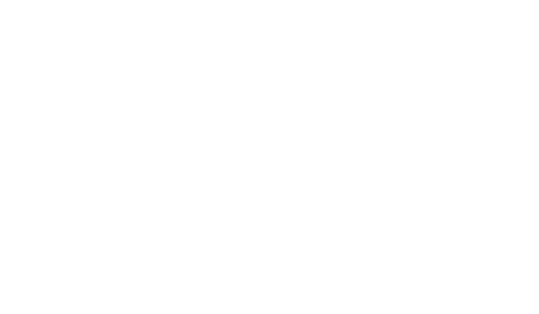

Text(37.597222222222214, 0.5, 'Frequency of occurance')

In [27]:
fig_ba_kde0, ax_ba_kde0 = plt.subplots(1, 1, figsize=(6, 3.5))
fig_ba_kde0.tight_layout(pad=3.0)
ax_ba_kde0.stem(pdf[:, 0]*255,
                  pdf[:, 1] * num_values,
                  markerfmt=".",
                  label="Unsmoothed Histogram")
ax_ba_kde0.legend(loc='best')
ax_ba_kde0.set_title("Un-normalised values from the histogram")
ax_ba_kde0.set_xlabel("Pixel intensity")
ax_ba_kde0.set_ylabel("Frequency of occurance")
# fig_ba_kde0.savefig(figpath+ "SmoothingHistB.png")






fig_ba_kde1, ax_ba_kde1 = plt.subplots(1, 1, figsize=(6, 3.5))
fig_ba_kde1.tight_layout(pad=3.0)

ax_ba_kde1.plot(unbound_kde_support*255,
                  unbound_kde_density,
                  color="orange",
                  lw=3,
                  label='Unbounded KDE from samples',
                  zorder=10)




ax_ba_kde1.plot(kde.support*255, (kde.density),"--",
                  lw=2,
                  color='green',
                  label='Bounded KDE from samples',
                  zorder=10)


ax_ba_kde1.legend(loc='best')
ax_ba_kde1.set_title("Un-normalised histogram smoothed with KDE")
ax_ba_kde1.set_xlabel("Pixel intensity")
ax_ba_kde1.set_ylabel("Frequency of occurance")

# fig_ba_kde1.savefig(figpath+ "SmoothingHistA.png")

In [28]:
plt.close('all')

In [29]:
gau = np.zeros(100)
gau[gau.shape[0]//2] = 1



## 2D KDE plots
---
<br>
<br>
<br>

In [30]:
    img=camera_data[0]
    proj_mat = make_proj_mat(data.calib.P_rect_00, data.calib.R_rect_00, data.calib.T_cam0_velo)
    pixel_locations, _, intensities = proj_lidar_to_image0(
        veloData[:, :3], veloData[:, 3], proj_mat, img.height, img.width)
    
    X = sample_img_at_lidar(pixel_locations, img)

    Y = np.floor(intensities * 255)

    lid_img = pts_to_img(pixel_locations,
                         Y,
                         [camera_data[0].height, camera_data[0].width],
                         dilate=True)

    cam_img = pts_to_img(pixel_locations,
                         X,
                         [camera_data[0].height, camera_data[0].width],
                         dilate=True)


In [80]:
Zhist, xedges, yedges = np.histogram2d(X, Y, bins=255)


In [31]:
from mpl_toolkits.mplot3d.axes3d import Axes3D


from matplotlib import cm

<IPython.core.display.Javascript object>


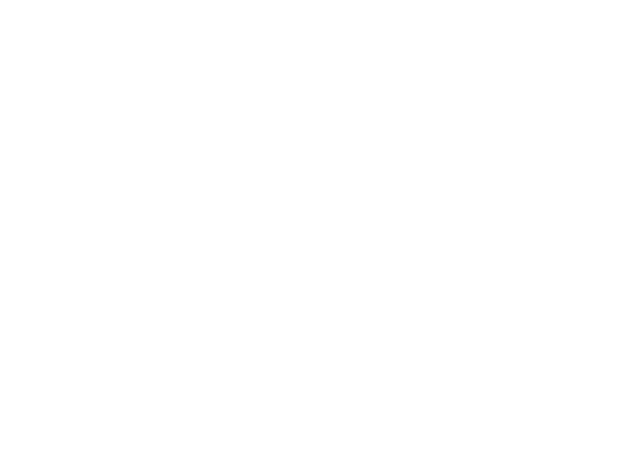

In [92]:
fig_3dH = plt.figure(figsize=(7, 5))
ax_3dH = fig_3dH.add_subplot(111, projection='3d')
fig_3dH.tight_layout(pad=2.0)


xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:])

xpos = xpos.flatten()/2.
ypos = ypos.flatten()/2.
zpos = np.zeros_like (xpos)

dx = xedges [1] - xedges [0]
dy = yedges [1] - yedges [0]
dz = Zhist.flatten()

cmap = cm.get_cmap('jet') # Get desired colormap - you can change this!
max_height = np.max(dz)   # get range of colorbars so we can normalize
min_height = np.min(dz)
# scale each z to [0,1], and get their rgb values
colors = plt.cm.coolwarm(dz/max_height)


ax_3dH.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors, zsort='average', alpha=0.8)
ax_3dH.set_title("Camera0 vs Projected Lidar Data",fontsize=15)
ax_3dH.set_xlabel("Camera0 Data")
ax_3dH.set_ylabel("Projected Lidar Data")
# ax_3dH.view_init(40, 45)

# fig_3dH.savefig(figpath+"Hist2Dplot3D.png")
plt.show()

In [93]:
plt.close("all")

<IPython.core.display.Javascript object>


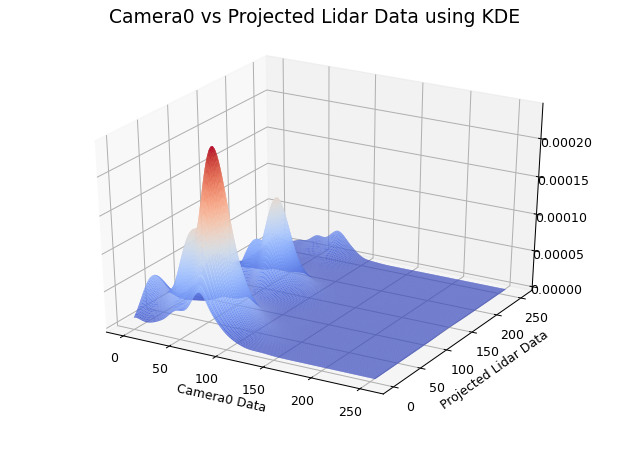

In [52]:
Zkde, xx, yy = get_kde_2D(X, Y, returnXY=True)

fig_3dKDE = plt.figure(figsize=(7, 5))
ax_3dKDE = fig_3dKDE.add_subplot(111, projection='3d')
fig_3dKDE.tight_layout(pad=2.5)

surf = ax_3dKDE.plot_surface(xx, yy, Zkde, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
# fig_3dKDE.colorbar(surf, shrink=0.5, aspect=5) # add color bar indicating the PDF
# ax_3dKDE.view_init(40, 45)

ax_3dKDE.set_title("Camera0 vs Projected Lidar Data using KDE", fontsize=15)
ax_3dKDE.set_xlabel("Camera0 Data")
ax_3dKDE.set_ylabel("Projected Lidar Data")
fig_3dKDE.savefig(figpath+"KDE2Dplot3D.png")
plt.show()

In [37]:
plt.close("all")

(255, 255)

## Digitising the kde:

<br>

<br>

<br>

In [27]:
tmp_bins = np.arange(0,255)/255
dig_inds = np.digitize(kde.support, bins=tmp_bins)
dig_1D_kde = np.zeros(2**8)
for i, inds in enumerate(dig_inds):
    dig_1D_kde[inds] += kde.density[i]

dig_1D_kde = dig_1D_kde[1:]

<IPython.core.display.Javascript object>


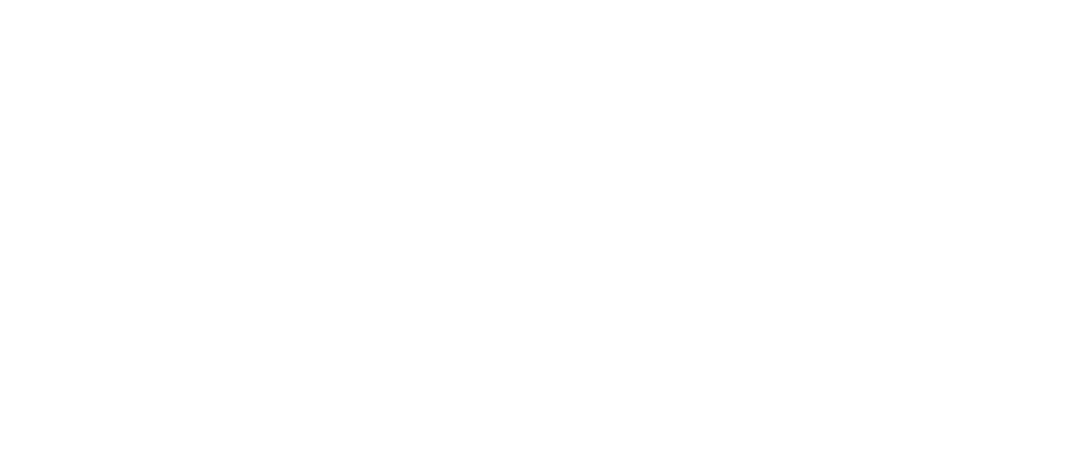

In [28]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)

ax.plot(tmp_bins, dig_1D_kde)

# Mutual Information Function:
---
TODO

## Setting up MI 

<IPython.core.display.Javascript object>


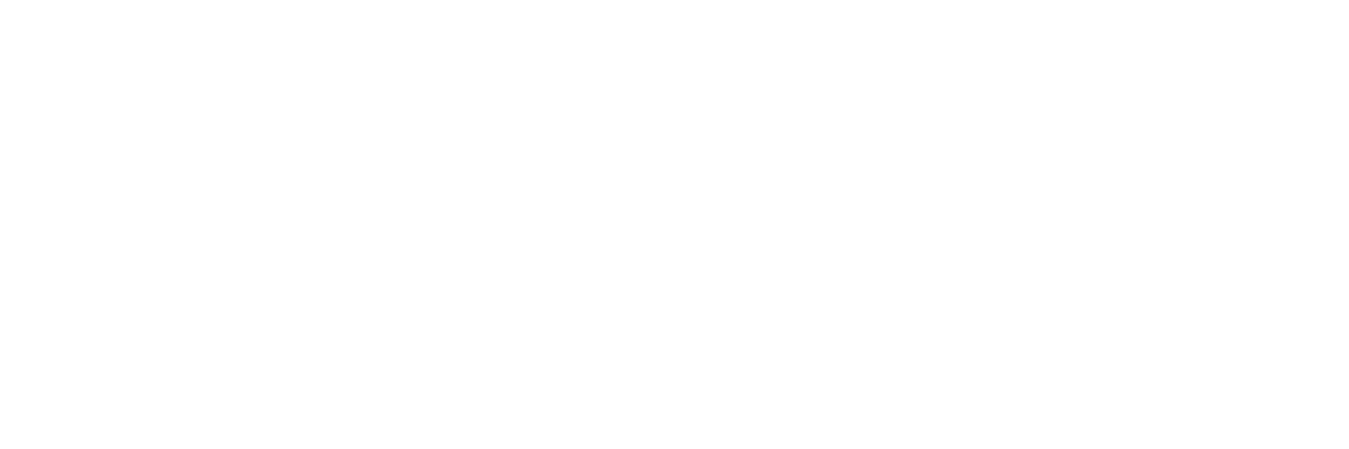

In [29]:
# 2D plot of the two images
im0 = np.array(camera_data[0])
im1 = np.array(camera_data[1])

fig_2im,ax_2im = plt.subplots(1,2,figsize=(15,5))
ax_2im[1].imshow(im0,cmap='gray')
ax_2im[0].imshow(im1, cmap='gray')

plt.show()

<IPython.core.display.Javascript object>


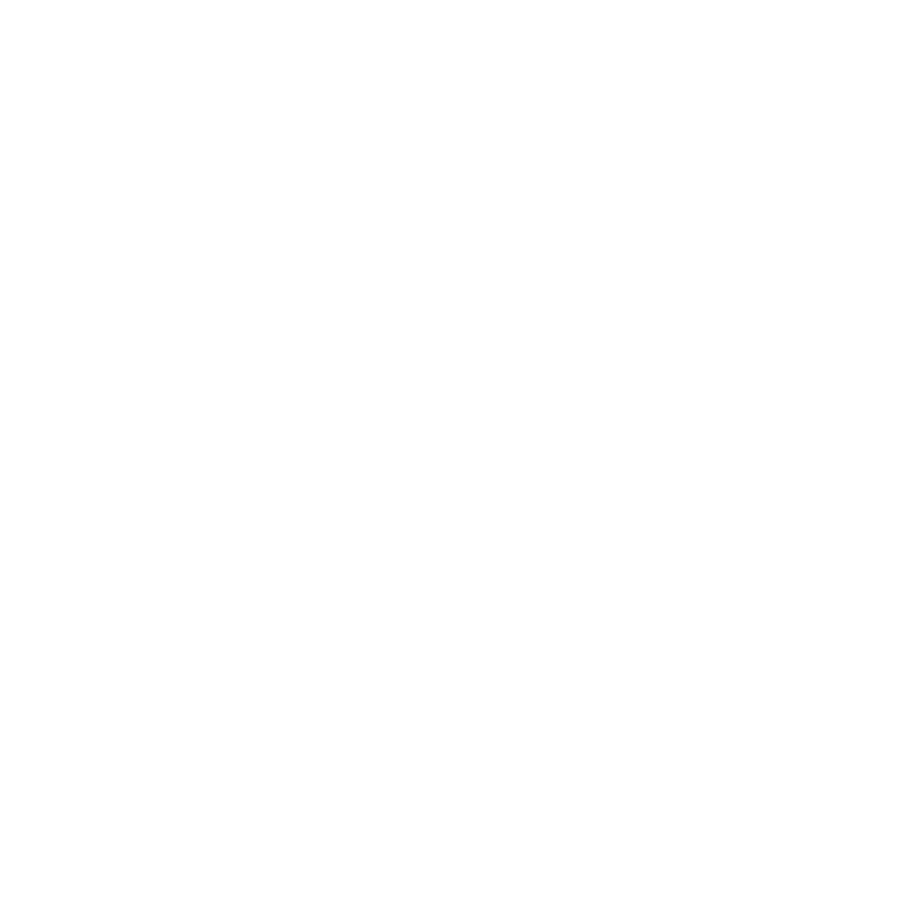

In [30]:
fig_2im_vs, ax_2im_vs = plt.subplots(2, 1, figsize=(10, 10))
fig_2im_vs.tight_layout(pad=3.0)

ax_2im_vs[0].plot(im0.ravel()[::50], im1.ravel()[::50], ".")
ax_2im_vs[0].set_title(
    "Plots of images against each other. (subsampled at 1/50)")
ax_2im_vs[0].set_xlabel("Camera 0")
ax_2im_vs[0].set_ylabel("Camera 1")

hist_2d, x_edges, y_edges = np.histogram2d(im0.ravel(),
                                           im1.ravel(),
                                           bins=20)
ax_2im_vs[1].imshow(hist_2d.T, origin='lower')

ax_2im_vs[1].set_title(
    "Histogram of images against each other. (subsampled at 1/50)")
ax_2im_vs[1].set_xlabel("Camera 0")
ax_2im_vs[1].set_ylabel("Camera 1")
plt.show()

Looking at the plots above, there's definitely a correlation between their pixel values from 0-150. 

This indicates that the images are pretty well aligned which is what we'd hope since they're visually almost the same.

In [31]:
plt.close("all")

## Getting a score for the Mutual Information Metric
---
<br><br>
Equation for Mutual Information:
<br>
$MI(X;Y) = \sum_{y \in Y} \sum_{x \in X} p(x,y) \log{ \left(\frac{p(x,y)}{p(x)\,p(y)}\right) }$
                              
Where:
- p(X) is the marginal probability for X
- p(X, Y) is the joing probability for X and Y


In [32]:
get_mutual_info_score(im0[::10],im1[::10])

1.1155710997343105

In [33]:
get_Normalised_mutual_info_score(im0[::10], im1[::10])

0.1063457252934276

def Theta_obj_function(X,Y,theta):
    Theta_hat = 


    return Theta_hat

## Getting the MI for different calibration parameters
--- 

<br>
<br>
For our objective function and the $[\mathcal{R}, t]$<br>
$Θ = [x,y,z,φ,θ,ψ]^⊤$
<br>
<br>

For the next step, the lidar point needs to be projected back into the camera's image plane. 

<br>
<br>

For iterating to find the optimal solution:
- Find the gradient at the point 
    - $G= \nabla MI(X, Y; \Theta) $
    - $\Theta_{k+1} = \Theta_{k} + \gamma_k \frac{G_k}{||G_k||}$
    - $\gamma_k = \dfrac{s_k^T s_k}{s_k^T g_k}$
    - where $s_k = \Theta_k − \Theta_{k−1}$ and $g_k = G_k − G_{k−1}$

TODO:
1. How to numerically compute the gradient


The projection of a 3D point $x = (x, y, z, 1)^T$ in rectified
(rotated) camera coordinates to a point $y = (u, v, 1)^T$ in the
i’th camera image is given as:
$y=P^{(i)}_{rect} x$


Constructing $P_{rect}^{(i)}$ for camera $i$:
<br> 
$P_{rect}^{(i)} = \pmatrix{f_u^{(i)} & 0 & c_u^{(i)} & -f_u^{(i)}b_x^{(i)}\\
                     0 & f_v^{(i)} & c_v^{(i)}& 0\\
                     0 & 0  &  1  &  0}
$
<br>
Where:
- $b_x$ denotes the baseline (in
meters) with respect to reference camera 0

- In order to project a 3D point $x$ in reference camera coordinates to a point $y$ on the i’th image plane:
    - $ y = P^{(i)}_{rect}R^{(0)}_{rect}x$

# Normalised Information Score
----
<br>
<br>
<br>


# Projections and displaying LiDAR overlaying camera
---
https://github.com/darylclimb/cvml_project/blob/master/projections/lidar_camera_projection/


In [48]:
from Lidar_Cam_Operations import *
from render_lidar_on_cam import *

In [35]:

# --------------------------------------------------------------------------------------------------------


In [36]:
def render_lidar_on_image0(pts_velo,intens, img, proj_velo2cam0, img_height, img_width, plt_depth=False, plt_pts_on_img = False):
    
    pixel_locations, depths, intensities = proj_lidar_to_image0(pts_velo, intens, proj_velo2cam0, img_height, img_width)
    cmap = plt.cm.get_cmap('hsv', 256)
    cmap = np.array([cmap(i) for i in range(256)])[:, :3] * 255
    
    if plt_pts_on_img:
        for i in range(pixel_locations.shape[0]):
            if plt_depth:
                colour = cmap[int(1280 / depths[i]), :]
            else:
                colour = cmap[int(255*intensities[i]), :]

            cv2.circle(img, (int(np.round(pixel_locations[i, 0])),
                             int(np.round(pixel_locations[i, 1]))),
                       1, color=tuple(colour), thickness=1)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    if plt_depth:
        ints = depths
    else:
        ints = intensities
        
        
    pixel_locations = np.floor(np.vstack((pixel_locations[:, 1], pixel_locations[:, 0])).T).astype(int)
    return img, pixel_locations, ints

In [49]:
plt.figure(num=1, figsize=(15,5))
img_cam0 = cv2.cvtColor(np.array(camera_data[0]), cv2.COLOR_RGB2RGBA)
img_cam0 = np.array(img_cam0)
# img_cam0 = np.zeros(img_cam0.shape)
# plt.imshow(img_cam0)
img_cam_lidar, lid_pix_loc, lidar_intensities =render_lidar_on_image0(veloData[:,:3], veloData[:,3], img_cam0,
                                                    project_velo_to_cam0(data.calib), camera_data[0].width, 
                                                    camera_data[0].height, plt_depth=True, plt_pts_on_img=True)
lid_pix_loc = np.floor(np.vstack((lid_pix_loc[:,1], lid_pix_loc[:,0])).T).astype(int)

plt.imshow(img_cam_lidar)
plt.title("Lidar points projected onto image from camera 0",fontsize=20)
# plt.savefig(figpath+"lidProjOntoCam0.png")
plt.tight_layout(pad=2.0)

In [51]:
plt.close('all')

<IPython.core.display.Javascript object>


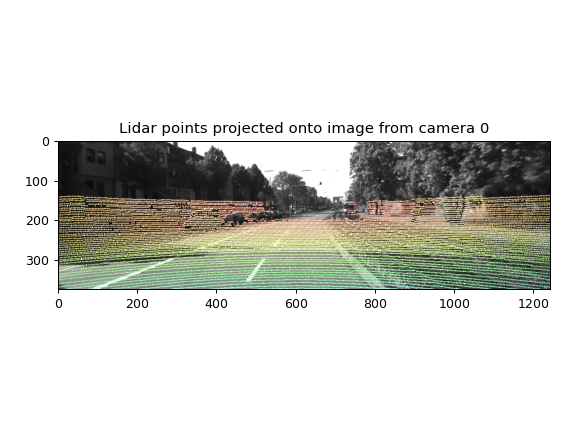

In [52]:
# # plt.imshow(camera_data[0], cmap='gray')
# plt.imshow(img_cam_lidar)
# plt.title("Lidar points projected onto image from camera 0")
# # plt.savefig(figpath+"lidProjOntoCam0.png")
# plt.tight_layout(pad=2.0)

<IPython.core.display.Javascript object>


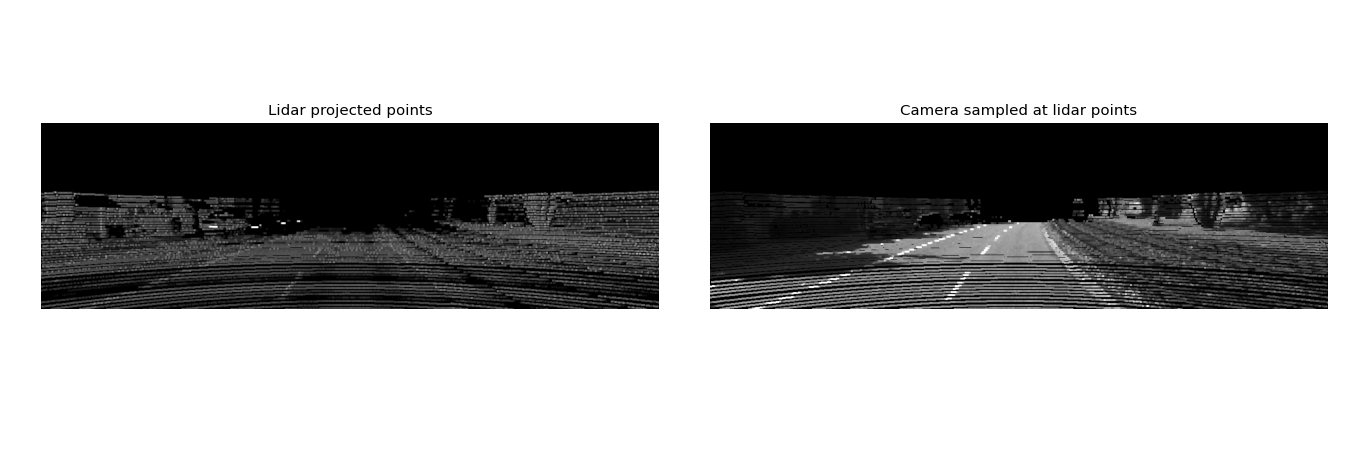

(19157, 2)


(-0.5, 1241.5, 374.5, -0.5)

In [56]:
fig_li, ax_li = plt.subplots(1,2, figsize=(15,5))

proj_mat = make_proj_mat(data.calib.P_rect_00, data.calib.R_rect_00, data.calib.T_cam0_velo)
img_cam_lidar, lid_pix_loc, lidar_intensities = render_lidar_on_image0(
    veloData[:, :3],
    veloData[:, 3],
    np.array(camera_data[0]),
    proj_mat,
    camera_data[0].width,
    camera_data[0].height,
    plt_depth=False, plt_pts_on_img = True)
print(lid_pix_loc.shape)



img_Img_lidar_proj_d = pts_to_img(lid_pix_loc,
                                  lidar_intensities * 255, 
                                  [camera_data[0].height, camera_data[0].width],
                                  dilate=True)


img_cam0_s_lidar_d = pts_to_img(lid_pix_loc,
                                sample_img_at_lidar(lid_pix_loc,
                                                    camera_data[0]),
                                [camera_data[0].height, camera_data[0].width],
                                dilate=True)

fig_li.tight_layout(pad=1.0)
ax_li[0].imshow(img_Img_lidar_proj_d)
ax_li[0].set_title("Lidar projected points")
ax_li[0].axis('off')

ax_li[1].imshow(img_cam0_s_lidar_d)
ax_li[1].set_title("Camera sampled at lidar points")
ax_li[1].axis('off')

In [ ]:
print(get_mutual_info_score(lidar_intensities, sample_img_at_lidar(lid_pix_loc, camera_data[0])))

# Searching for optimal $u$ and $v$ 
---

Camera 0 is the reference frame. 
<br>
Lidar will be shifted by moving the projected lidar image and comparing it to cam0's image.
<br>
Once the best match is found for the $u$ and $v$ shift that gives the best match, this will be taken back into the $P_{rect}, R_{rect}$ transforms


---
For reference, recall that: 

<br>
$P_{rect}^{(i)} = \pmatrix{f_u^{(i)} & 0 & c_u^{(i)} & -f_u^{(i)}b_x^{(i)}\\
                     0 & f_v^{(i)} & c_v^{(i)}& 0\\
                     0 & 0  &  1  &  0}
$
<br>
So we can extract the starting parameters.

In [55]:
def make_proj_mat(P, Rrect, Rt):
    P_velo2cam_ref = Rt
    R_ref2rect = np.linalg.inv((Rrect))
    P_rect2cam2 = P

    proj_mat = P_rect2cam2 @ R_ref2rect @ P_velo2cam_ref
    return proj_mat

In [ ]:
def get_P_params(P):
    fu = P[0,0]
    cu = P[0,2]
    bx = P[0,3]/(-fu)
    fv = P[1,1]
    cv = P[1,2]
    
    P_params = [fu, cu, bx, fv, cv]
    return P_params

def get_Rt_params(Rt):
    Rt = Rt[:3,:]
    R = Rt[:,:3]
    R = np.linalg.inv(R)
    t = Rt[:,3]
#     print(Rt)
#     print(R)
#     print(t)
    return R, t
# ------------------------------------------------------
# Making Rt
# ------------------------------------------------------

def make_P(P_params):
    fu = P_params[0]
    cu = P_params[1]
    bx = P_params[2]
    fv = P_params[3]
    cv = P_params[4]
    return np.array([[fu, 0 , cu, -fu*bx],
                     [0 , fv, cv,   0   ],
                     [0,  0,   1,   0]])

def make_Rt(R,t):
    R = np.reshape(R,(3,3))
    R = np.linalg.inv(R)
    t = np.reshape(t,(3,1))
    Rt = np.vstack((np.hstack((R,t)), [0,0,0,1]))
    return(Rt)


In [ ]:
print(data.calib.P_rect_00)
print(make_P(get_P_params(data.calib.P_rect_00)))

print()
Rt = np.matmul(np.linalg.inv(data.calib.R_rect_00),data.calib.T_cam0_velo)
print(Rt)
print(make_Rt(get_Rt_params(Rt)[0],get_Rt_params(Rt)[1] ))


# Changing parameters in the calibration
----

Modifying the starting parameters by in the direction of improvement
<br>
Recall:
<br>
- For our objective function and the $[\mathcal{R}, t]$
    - $Θ = [x,y,z,\phi,\theta,\psi]^⊤$
    - $\phi$ is a euler rotation about the $x$-axis
    - and for $\theta$ and $\psi$, $y$ and $z$ respectively
    
   <br>
- Step size vector is given by:
    - $\gamma$ for $\Theta$
<br>
<br>

Matrix representations:
To get the velodyne into image coordinates:
$\begin{bmatrix}u\\f\\1\end{bmatrix} =
P_{\text{rect-to-cam0}} \;.\, R_\text{cam_ref_plane-to-rect} \;.\, P_\text{velo-to-cam_ref_plane} \,.\,
\begin{bmatrix}{x\\y\\z\\1} \end{bmatrix}$

<br><br>
After multiplying $R_\text{cam_ref_plane-to-rect} \;.\, P_\text{velo-to-cam_ref_plane}$ we get a single matrix that needs optimizing:

$\pmatrix{
r_{11} & r_{12} & r_{13} & t_1\\
r_{21} & r_{22} & r_{23} & t_2\\
r_{31} & r_{32} & r_{33} & t_3\\
0 & 0 & 0 & 1
}$
<br>

---
Note: this might not be right

--- 
<br>
where $r$ is the rotational component and $t$ is the translational component.

<br>
<br>
Therefore the optimization problem looks as follows:
<br>
$\begin{bmatrix}u\\f\\1\end{bmatrix} =
\pmatrix{f_u^{(i)} & 0 & c_u^{(i)} & -f_u^{(i)}b_x^{(i)}\\
                     0 & f_v^{(i)} & c_v^{(i)}& 0\\
                     0 & 0  &  1  &  0}
\pmatrix{
r_{11} & r_{12} & r_{13} & t_1\\
r_{21} & r_{22} & r_{23} & t_2\\
r_{31} & r_{32} & r_{33} & t_3\\
0 & 0 & 0 & 1
}
\begin{bmatrix}{x\\y\\z\\1} \end{bmatrix}
$



Plan of action:
- get starting parameters
- declare initial step size $\gamma_0$

loop:
- get MI for $\Theta_n$
- shift them by the adaptive step size $\gamma_n \frac{\nabla \Theta_n}{||\nabla \Theta_n||}$
- get MI for $\Theta_{n+1}$
- work out $\nabla \Theta_{n+1}$ and $\gamma_{n+1}$



In [ ]:
def get_gn(Th_n, Th_n1, G_n, G_n1):
    sk = np.subtract(Th_n,Th_n1)
    gk = np.subtract(G_n,G_n1)
#     gn = np.divide(sk* sk, sk* gk)
    gn = (sk.T@sk)/(sk.T@gk)
    return gn

def get_Gn_1(score_n, score_n1, gn):
    Gn_1 = np.subtract(score_n1, score_n)/gn
    return Gn_1


def step_Th(Th_n, G_n, gn):
    return Th_n + gn * np.divide(G_n, np.linalg.norm(G_n))

def make_Thn(P, Rt):
#     P_params = get_P_params(P)
    R, t = get_Rt_params(Rt)
#     return np.hstack((P_params, R.ravel(), t.ravel()))
    return np.hstack((R.ravel(), t.ravel()))

def Thn_to_Arrs(Thn):
#     P = make_P(Thn[:5])
#     R = Thn[5:-3]
#     t = Thn[-3:]
#     Rt = make_Rt(R,t)
#     return P,Rt
    R = Thn[:-3]
    t = Thn[-3:]
    Rt = make_Rt(R,t)
    return Rt
    
def get_Rt(R_rect_00, T_cam0_velo):
    return np.matmul(np.linalg.inv(R_rect_00),T_cam0_velo)


In [ ]:
def score_Thnp1(Th_n, Th_np1, velo, img):
    """
    Thn : parameters [17x1]
    velo: xyzi
    img: grayscale img
    
    Takes Thn:
        - Makes P and Rt
        - Projects Lidar
        - Samples image at same places as lidar pts
        - Makes Lidar image
        - gets MI score for two imgs
        - returns MI score
    """
    th_scores = np.zeros(Th_n.shape)
    print("Th scores: ", end="")
    
    for k, th_k in enumerate(Th_np1):
        this_Thn = Th_n.copy()
        this_Thn[k] = th_k
        
        
#         P, Rt = Thn_to_Arrs(this_Thn)
        Rt = Thn_to_Arrs(this_Thn)
        proj_mat = P @ Rt 
        pixel_locations, _, intensities = proj_lidar_to_image0(velo[:,:3], velo[:,3], proj_mat, img.height, img.width)
        syn_cam_lidar = sample_img_at_lidar(pixel_locations, img)
        
        th_scores[k] = get_mutual_info_score(intensities, syn_cam_lidar)
        print(" ", th_scores[k], end="")
    
    print()
    return th_scores
    
    
    
    
    

In [ ]:
def mod_calib(calib, errorMultiplier=0.01):
    nc = copy.deepcopy(calib)
    nR_rect= np.add(
        nc.R_rect_00,
        nc.R_rect_00 *(np.random.rand(nc.R_rect_00.shape[0], nc.R_rect_00.shape[1]) - 0.5) *
        errorMultiplier)

    nT_velo = np.add(
        nc.T_cam0_velo,
        nc.T_cam0_velo *(np.random.rand(nc.T_cam0_velo.shape[0], nc.T_cam0_velo.shape[1]) - 0.5) *
        errorMultiplier)

    nP = np.add(
        nc.P_rect_00,
        nc.P_rect_00 * (np.random.rand(nc.P_rect_00.shape[0], nc.P_rect_00.shape[1]) - 0.5) *
        errorMultiplier)
    
    nRt = get_Rt(nR_rect, nT_velo)

    return nP, nRt


def init_Thn_Gn_gn(P, Rt, alpha=0.01, rnd_seed=1):
    np.random.seed(rnd_seed)
    

    Thn = make_Thn(P, Rt)
    shp = Thn.shape[0]  # Thn is a 1D array
    Gn = np.random.rand(shp)
    gn = alpha * (np.random.rand(1) - 0.5)

    return Thn, Gn, gn

In [ ]:
P = data.calib.P_rect_00
Rt = get_Rt(data.calib.R_rect_00, data.calib.T_cam0_velo)
Thn, Gn, gn = init_Thn_Gn_gn(P, Rt, alpha=1E-6)
print(Thn)
print(get_Rt(data.calib.R_rect_00, data.calib.T_cam0_velo))
print(Gn)
print(gn)


In [ ]:
Thn1= step_Th(Thn, Gn, gn)
score_n = score_Thnp1(Thn, Thn, data.get_velo(frame_num), camera_data[0])
score_n1  = score_Thnp1(Thn, Thn1, data.get_velo(frame_num), camera_data[0])

In [ ]:
Gn1 = get_Gn_1(score_n, score_n1, gn)

gn1 = get_gn(Thn, Thn1, Gn, Gn1)
# print(score_n)
# print()
# print(score_n1,"\n\n" ,Gn1, "\n\n", gn1)
gn1

In [ ]:
# Lets see what happens when we let it loose:

its = 100
gns = np.zeros(its)

# Gns = np.zeros((its, 17 ))
# MIscores = np.zeros((its, 17))
# Ths = np.zeros((its, 17 ))

Gns = np.zeros((its, 12 ))
MIscores = np.zeros((its, 12))
Ths = np.zeros((its, 12 ))
velo = np.array(data.get_velo(frame_num))
img0 = camera_data[0]

noisyP, noisyRt = mod_calib(data.calib, errorMultiplier=0.00000001)

P = data.calib.P_rect_00
Ths[0,:], Gns[0,:], gns[0]   = init_Thn_Gn_gn(noisyP, noisyRt, alpha=1E-6)


MIscores[0] = score_Thnp1(Ths[0], Ths[0], velo,img0)
    
for i in range(1,10):
#     print(Ths[i-1], Gns[i-1], gns[i-1], sep='\n')
    Ths[i] = step_Th(Ths[i-1], Gns[i-1], gns[i-1])
    MIscores[i] = score_Thnp1(Ths[i-1], Ths[i], velo, img0)
    
    Gns[i] = get_Gn_1(MIscores[i-1], MIscores[i], gns[i-1])
    gns[i] = get_gn(Ths[i-1], Ths[i], Gns[i], Gns[i-1])
    

In [ ]:
MIscores[0] = score_Thnp1(Ths[0], Ths[0], velo,img0)

In [ ]:
# fig,ax = plt.subplots(17,1, figsize=(5,17*2))
# fig.tight_layout(pad=2.0)

# for i in range(0,17):
#     ax[i].plot(np.arange(0,100),MIscores[:100, i])
#     ax[i].set_title("MI Score for Th[{}]".format(i))

fig,ax = plt.subplots(3,1, figsize=(15,5))
fig.tight_layout(pad=2.0)

ax[0].plot(np.arange(0,100),MIscores[:100, i])
ax[0].set_title("MI Score")

ax[1].plot(np.arange(0,100),gns[:100])
ax[1].set_title("Step size $\gamma$")

ax[2].plot(np.arange(0,100),Gns[:100,0])
ax[2].set_title("Gradient of Th[0]")

In [ ]:
# tmpP, tmpRt = Thn_to_Arrs(Ths[0])
tmpRt = Thn_to_Arrs(Ths[0])

tmpim, lid, inten = render_lidar_on_image0(
    data.get_velo(frame_num)[:, :3],
    data.get_velo(frame_num)[:, 3] * 255, np.array(camera_data[0]),
    tmpP @ tmpRt, camera_data[0].height, camera_data[0].width)

In [ ]:
figt, axt = plt.subplots(1,2, figsize=(15,5))
figt.tight_layout(pad=1.0)
axt[0].imshow(pts_to_img(lid, inten, np.array(camera_data[0]).shape, dilate=True))
axt[0].set_title("What the LiDAR sees:")
axt[0].axis('off')

axt[1].imshow(pts_to_img(lid, sample_img_at_lidar(lid,camera_data[0]), np.array(camera_data[0]).shape, dilate=True))
axt[1].set_title("The same spots in the camera")
axt[1].axis('off')

# inten

In [ ]:
figt.tight_layout(pad=1.0)

In [ ]:
if np.sum(0):
    print(True)

In [ ]:
step_Th(Thn, Gn, gn)

# Scene Discriptor

---

$ φ^{j}_{n}(θ_n) = D^j(X, Y ; g_{CL} ⊕ \theta_n) − D_j(X, Y ; g_{CL})$



In [ ]:
def scene_d_n(X_gcl, Y_gcl, X_gcl_th, Y_gcl_th):
    return D(X_gcl_th, Y_gcl_th) - D(X_gcl, Y_gcl)


# Displaying Data

In [ ]:
# cam0_xlim = camera_data[0].width
# cam0_ylim = camera_data[0].height



# x_in = np.logical_and(x[:,1]>=-cam0_ylim, x[:,1]<=cam0_ylim)
# y_in = np.logical_and(x[:,0]>=0, x[:,0]<=cam0_xlim)
# indicies = np.logical_and(x_in, y_in)
# x_inframe = x[indicies]
# intens_inframe = intens[indicies]


# # pos_ind = np.logical_and(x[:,1]>=0), x[:,0]>=0)
# # pos_ind = x[:,0]>=0
# x_pos = x[pos_ind]
# intens_pos = intens[pos_ind]



In [ ]:
fig_lvsc, a_lvsc = plt.subplots(1, 2, figsize=(15, 5))
fig_lvsc.tight_layout(pad=3.0)

a_lvsc[0].plot(lidar_intensities.ravel()[::5], cam0_lidarPts.ravel()[::5], ".")
a_lvsc[0].set_title("Plots of images against each other. (subsampled at 1/5)")
a_lvsc[0].set_xlabel("Lidar")
a_lvsc[0].set_ylabel("Cam 0")

hist_2d, _, _ = np.histogram2d(lidar_intensities.ravel(),
                               cam0_lidarPts.ravel(),
                               bins=255)

hist_2d_log = np.zeros(hist_2d.shape)
non_zeros = hist_2d != 0
hist_2d_log[non_zeros] = np.log(hist_2d[non_zeros])

a_lvsc[1].imshow(hist_2d_log.T, origin='lower')
a_lvsc[1].set_title(
    "Logorithmic histogram of images against each other. (subsampled at 1/50)")
a_lvsc[1].set_xlabel("Lidar")
a_lvsc[1].set_ylabel("Cam 0")

plt.show()

In [ ]:
get_mutual_info_score(cam0_lidarPts,lidar_intensities)

In [124]:
def make_proj_mat(P, Rrect, Rt):
    P_velo2cam_ref = Rt
    R_ref2rect = np.linalg.inv((Rrect))
    P_rect2cam2 = P

    proj_mat = P_rect2cam2 @ R_ref2rect @ P_velo2cam_ref
    return proj_mat

def eulerAnglesToRotationMatrix(theta):

    R_x = np.array([[1, 0, 0], [0, math.cos(theta[0]), -math.sin(theta[0])],
                    [0, math.sin(theta[0]),
                     math.cos(theta[0])]])

    R_y = np.array([[math.cos(theta[1]), 0,
                     math.sin(theta[1])], [0, 1, 0],
                    [-math.sin(theta[1]), 0,
                     math.cos(theta[1])]])

    R_z = np.array([[math.cos(theta[2]), -math.sin(theta[2]), 0],
                    [math.sin(theta[2]),
                     math.cos(theta[2]), 0], [0, 0, 1]])

    R = np.dot(R_z, np.dot(R_y, R_x))

    return R

# Checks if a matrix is a valid rotation matrix.
def isRotationMatrix(R):
    Rt = np.transpose(R)
    shouldBeIdentity = np.dot(Rt, R)
    I = np.identity(3, dtype=R.dtype)
    n = np.linalg.norm(I - shouldBeIdentity)
    return n < 1e-6


# Calculates rotation matrix to euler angles
# The result is the same as MATLAB except the order
# of the euler angles ( x and z are swapped ).

import math


def rotationMatrixToEulerAngles(R):

    assert (isRotationMatrix(R))

    sy = math.sqrt(R[0, 0] * R[0, 0] + R[1, 0] * R[1, 0])

    singular = sy < 1e-6

    if not singular:
        x = math.atan2(R[2, 1], R[2, 2])
        y = math.atan2(-R[2, 0], sy)
        z = math.atan2(R[1, 0], R[0, 0])
    else:
        x = math.atan2(-R[1, 2], R[1, 1])
        y = math.atan2(-R[2, 0], sy)
        z = 0

    return np.array([x, y, z])

def getTheta(Rt):
    R = Rt[:3, :3]
    t = Rt[:3, 3]
    ang = rotationMatrixToEulerAngles(R)
    return np.hstack((t, ang))

def make_Rt(Theta):
    t = Theta[:-3][:, np.newaxis]
    ang = Theta[-3:]
    R = eulerAnglesToRotationMatrix(ang)
    Rt = np.vstack((np.hstack((R, t)), [0, 0, 0, 1]))
    return Rt

def mod_calib(calib, errorMultiplier=1E-5):
    Rt = calib.T_cam0_velo

    th = getTheta(Rt)
    nTh = np.add(th, th * (np.random.rand(th.shape[0]) - 0.5) * errorMultiplier)
    nRt = make_Rt(nTh)
    return nTh, nRt

In [129]:
frame_nums = np.arange(0,9, 2) # When the frames were imported they were stepped in 5's

MIscore_hist = np.zeros(frame_nums.shape[0])
MIscore_KDE = np.zeros(frame_nums.shape[0])
NMIscore_hist = np.zeros(frame_nums.shape[0])
NMIscore_KDE = np.zeros(frame_nums.shape[0])




noisyTh, noisyRt = mod_calib(data.calib, errorMultiplier=1)
noisyTh[3:] = getTheta(data.calib.T_cam0_velo)[3:]
noisyRt = make_Rt(noisyTh)
proj_mat = make_proj_mat(data.calib.P_rect_00, data.calib.R_rect_00, noisyRt)
print(noisyTh)
imgs = []

for s, f in enumerate(frame_nums):
    print("===============================================")
    print("FRAME #{}".format(f*5))
    print("===============================================")
    
    
    velo_f = data.get_velo(f)
    img_f = data.get_cam0(f)
    
    
    
     
    img_cam_lidar, lid_pix_loc, lidar_intensities = render_lidar_on_image0(
        velo_f[:, :3],
        velo_f[:, 3],
        np.array(img_f),
        proj_mat,
        img_f.width,
        img_f.height,
        plt_depth=False, plt_pts_on_img = False)
    imgs.append(img_cam_lidar)


#     img_Img_lidar_proj_d = pts_to_img(lid_pix_loc,
#                                       lidar_intensities * 255, 
#                                       [img_f.height, img_f.width],
#                                       dilate=True)[::4]


#     img_cam0_s_lidar_d = pts_to_img(lid_pix_loc,
#                                     sample_img_at_lidar(lid_pix_loc,
#                                                         img_f),
#                                     [img_f.height, img_f.width],
#                                     dilate=True)[::4]
    cam_pts = sample_img_at_lidar(lid_pix_loc,img_f),
    
    MIscore_hist[s] = get_mutual_info_score(lidar_intensities, cam_pts ,use_hist=True)
    print(MIscore_hist[s])
    MIscore_KDE[s] = get_mutual_info_score(lidar_intensities, cam_pts, use_hist=False)
    print(MIscore_KDE[s])
    NMIscore_hist[s] = get_Normalised_mutual_info_score(lidar_intensities, cam_pts,use_hist=True)
    print(NMIscore_hist[s])
    NMIscore_KDE[s] = get_Normalised_mutual_info_score(lidar_intensities, cam_pts, use_hist=False)
    print(NMIscore_KDE[s])
    
    

[-0.00221398 -0.08424954 -0.36960123  0.01189895 -1.56034409  1.54833245]
FRAME #0
0.32054040258604366
0.0027580849431533944
0.033261278637321944
0.00028619615829864677
FRAME #10
0.3320687738882505
0.001046205352412559
0.03456178686453531
0.00010888927008471813
FRAME #20
0.3147743318499643
0.003612104537775854
0.032755622867874944
0.0003758779608977797
FRAME #30
0.3242844699867312
0.00016359182382823953
0.033771825528991536
1.7036876704341974e-05
FRAME #40
0.297185453851082
0.004120417665731505
0.03085950945203147
0.0004278610081827054


In [130]:
frame_nums = np.arange(0,9, 2) # When the frames were imported they were stepped in 5's

MIscore_hist_gt = np.zeros(frame_nums.shape[0])
MIscore_KDE_gt = np.zeros(frame_nums.shape[0])
NMIscore_hist_gt = np.zeros(frame_nums.shape[0])
NMIscore_KDE_gt = np.zeros(frame_nums.shape[0])



proj_mat = make_proj_mat(data.calib.P_rect_00, data.calib.R_rect_00, data.calib.T_cam0_velo)
print(noisyTh)
imgs = []

for s, f in enumerate(frame_nums):
    print("===============================================")
    print("FRAME #{}".format(f*5))
    print("===============================================")
    
    
    velo_f = data.get_velo(f)
    img_f = data.get_cam0(f)
    
    
    
     
    img_cam_lidar, lid_pix_loc, lidar_intensities = render_lidar_on_image0(
        velo_f[:, :3],
        velo_f[:, 3],
        np.array(img_f),
        proj_mat,
        img_f.width,
        img_f.height,
        plt_depth=False, plt_pts_on_img = False)
    imgs.append(img_cam_lidar)


#     img_Img_lidar_proj_d = pts_to_img(lid_pix_loc,
#                                       lidar_intensities * 255, 
#                                       [img_f.height, img_f.width],
#                                       dilate=True)[::4]


#     img_cam0_s_lidar_d = pts_to_img(lid_pix_loc,
#                                     sample_img_at_lidar(lid_pix_loc,
#                                                         img_f),
#                                     [img_f.height, img_f.width],
#                                     dilate=True)[::4]
    cam_pts = sample_img_at_lidar(lid_pix_loc,img_f),
    
    MIscore_hist_gt[s] = get_mutual_info_score(lidar_intensities, cam_pts ,use_hist=True)
    print(MIscore_hist_gt[s])
    MIscore_KDE_gt[s] = get_mutual_info_score(lidar_intensities, cam_pts, use_hist=False)
    print(MIscore_KDE_gt[s])
    NMIscore_hist_gt[s] = get_Normalised_mutual_info_score(lidar_intensities, cam_pts,use_hist=True)
    print(NMIscore_hist_gt[s])
    NMIscore_KDE_gt[s] = get_Normalised_mutual_info_score(lidar_intensities, cam_pts, use_hist=False)
    print(NMIscore_KDE_gt[s])
    
    

[-0.00221398 -0.08424954 -0.36960123  0.01189895 -1.56034409  1.54833245]
FRAME #0
0.30849496976563556
0.0026085778075801134
0.03196129343911963
0.00027025893106193084
FRAME #10
0.3259573263708189
0.0011286396679918305
0.03387020369573927
0.00011727687142238479
FRAME #20
0.3162992044329711
0.004026076607364164
0.032860616162194524
0.00041827281314651716
FRAME #30
0.31399501968898924
0.00015877329538079254
0.032647079181161734
1.6508173764300256e-05
FRAME #40
0.2960255724751142
0.004478209754384227
0.03068838849941258
0.0004642471918062259


In [80]:
NMIscore_KDE
NMIscore_hist_gt

array([0.03196129, 0.0338702 , 0.03286062, 0.03264708, 0.03068839])

<IPython.core.display.Javascript object>


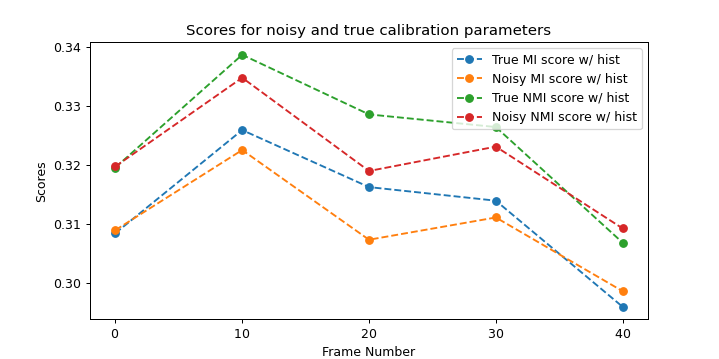

In [118]:
fig_scores_gt, ax_scores_gt = plt.subplots(1,1, figsize=(8,4))
frame_nums = [" 0 ", " 10 ", " 20 ", " 30 ", " 40 "]
ax_scores_gt.plot(frame_nums, MIscore_hist_gt, "o--",label="True MI score w/ hist")
ax_scores_gt.plot(frame_nums, MIscore_hist, "o--",label="Noisy MI score w/ hist")
# ax_scores_gt.plot(frame_nums, MIscore_KDE_gt*100, "o--",label="True MI score w/ KDE")
ax_scores_gt.plot(frame_nums, NMIscore_hist_gt*10, "o--",label="True NMI score w/ hist")
ax_scores_gt.plot(frame_nums, NMIscore_hist*10, "o--",label="Noisy NMI score w/ hist")
# ax_scores_gt.plot(frame_nums, NMIscore_KDE_gt*100, "o--",label="True NMI score w/ KDE")

ax_scores_gt.set_title("Scores for noisy and true calibration parameters")
ax_scores_gt.set_xlabel("Frame Number")
ax_scores_gt.set_ylabel("Scores")
ax_scores_gt.legend(loc='best')

# ax_scores_gt.set_xticks(frame_nums,labels)

# fig_scores_gt.savefig(figpath + "HistCalScores.png")
plt.show()

<IPython.core.display.Javascript object>


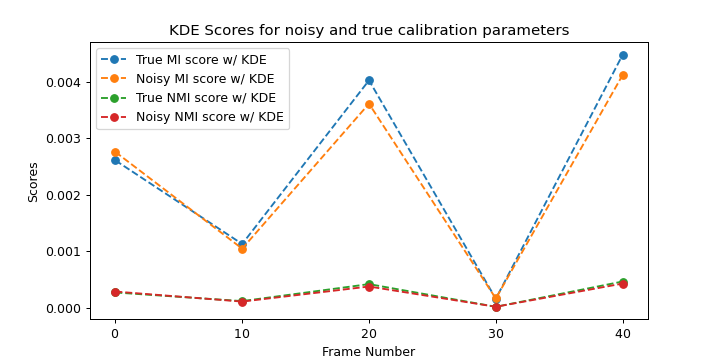

In [131]:
fig_scores, ax_scores = plt.subplots(1,1, figsize=(8,4))
frame_nums = [" 0 ", " 10 ", " 20 ", " 30 ", " 40 "]
ax_scores.plot(frame_nums, MIscore_KDE_gt, "o--",label="True MI score w/ KDE")
ax_scores.plot(frame_nums, MIscore_KDE, "o--",label="Noisy MI score w/ KDE")
# ax_scores.plot(frame_nums, MIscore_KDE*100, "o--",label="True MI score w/ KDE")
# ax_scores.plot(frame_nums, NMIscore_KDE_gt, "o--",label="True NMI score w/ KDE")
ax_scores.plot(frame_nums, NMIscore_KDE_gt, "o--",label="True NMI score w/ KDE")
ax_scores.plot(frame_nums, NMIscore_KDE, "o--",label="Noisy NMI score w/ KDE")
# ax_scores.plot(frame_nums, NMIscore_KDE*100, "o--",label="True NMI score w/ KDE")

ax_scores.set_title("KDE Scores for noisy and true calibration parameters")
ax_scores.set_xlabel("Frame Number")
ax_scores.set_ylabel("Scores")
ax_scores.legend(loc='best')

# ax_scores.set_xticks(frame_nums,labels)

# fig_scores.savefig(figpath + "KDECalScores.png")
plt.show()

In [91]:
for f in frame_nums:
    print("\"", f*5, "\"", end=", ")

"  0  0  0  0  0  ", "  10  10  10  10  10  ", "  20  20  20  20  20  ", "  30  30  30  30  30  ", "  40  40  40  40  40  ", 

In [110]:
print("MI scores (histogram)",
      np.round(np.mean(MIscore_hist_gt), 4),
      np.round(np.mean(MIscore_hist), 4),
      np.round(np.std(MIscore_hist_gt), 4),
      np.round(np.std(MIscore_hist), 4),
      sep=" & ",
      end=" \\\\\n")

print("NMI scores (histogram)",
      np.round(np.mean(NMIscore_hist_gt), 4),
      np.round(np.mean(NMIscore_hist), 4),
      np.round(np.std(NMIscore_hist_gt), 4),
      np.round(np.std(NMIscore_hist), 4),
      sep=" & ",
      end=" \\\\\n")
print("MI scores (KDE)",
      np.round(np.mean(MIscore_KDE_gt), 4),
      np.round(np.mean(MIscore_KDE), 4),
      np.round(np.std(MIscore_KDE_gt), 4),
      np.round(np.std(MIscore_KDE), 4),
      sep=" & ",
      end=" \\\\\n")
print("NMI scores (KDE)",
      np.round(np.mean(NMIscore_KDE_gt), 4),
      np.round(np.mean(NMIscore_KDE), 4),
      np.round(np.std(NMIscore_KDE_gt), 4),
      np.round(np.std(NMIscore_KDE), 4),
      sep=" & ",
      end=" \\\\\n")

MI scores (histogram) & 0.3122 & 0.3095 & 0.0098 & 0.0091 \\
NMI scores (histogram) & 0.0324 & 0.0321 & 0.0011 & 0.001 \\
MI scores (KDE) & 0.0025 & 2.551 & 0.0017 & 1.6773 \\
NMI scores (KDE) & 0.0257 & 0.2644 & 0.0171 & 0.1738 \\


<IPython.core.display.Javascript object>


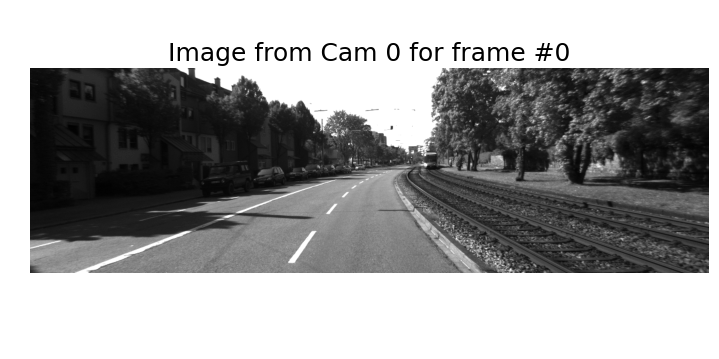

In [55]:
figtmp, axtmp = plt.subplots(1,1, figsize=(8,4))
figtmp.tight_layout(pad=0.1)
axtmp.imshow(camera_data[0], cmap='gray')
axtmp.set_title("Image from Cam 0 for frame #{}".format(frame_num*5), fontsize=20)
axtmp.axis("off")
# figtmp.savefig(figpath + "cam0frame0.png")

In [ ]:
camera_data[0].width*camera_data[0].height/lidar_intensities.shape[0]

In [ ]:
24.57*37/60
